In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import glob
import os
import re
from tqdm import tqdm_notebook

import artm
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder

# Run in terminal or command prompt
# python3 -m spacy download en
import nltk, spacy, gensim

# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
def plot_perp_and_sparsity(model, use_first_perp=False):
    f = plt.figure(figsize=(12,5))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    if use_first_perp:
        ax1.plot(model.score_tracker["perplexity_score"].value)
    else:
        ax1.plot(model.score_tracker["perplexity_score"].value[1:])
    ax1.set_title('perplexity')
    ax1.grid()
    ax2.plot(model.score_tracker["sparsity_theta_score"].value)
    ax2.plot(model.score_tracker["sparsity_phi_score"].value)
    ax2.set_title('$\\Phi$ and $\\Theta$ sparsity')
    ax2.grid()
    
def print_top_words(model, indexes=False):
    if not indexes:
        indexes = model.score_tracker["top_words"].last_tokens.keys()
    else:
        indexes = list(map(str, indexes))
    for topic_name in indexes:
        tokens = model.score_tracker["top_words"].last_tokens
        res_str = topic_name + ': ' + ', '.join(tokens[topic_name])
        print(res_str)

# Data preprocessing

In [7]:
# "../data" folder doesn't contain this file because it is too big for uploading
news_words = np.load('../data/news_data/preprocessed.npy')
news_target = fetch_20newsgroups('../data/news_data').target

X_train, X_test, y_train, y_test = \
    train_test_split(news_words, news_target, random_state=16)

In [ ]:
doc = -1

def to_vw_format_rtm(document, label, type="train"):
    global doc
    doc = doc +1
    if (type == "train"):
        return str("doc_" + str(doc)) + ' |@raw_text ' + ' '.join(re.findall('\w{3,}', document.lower()))\
            + ' |@origin ' + str(label or "0") + 'ss' + '\n'
    elif (type == "test"):
        return str("doc_" + str(doc)) + ' |@raw_text ' + ' '.join(re.findall('\w{3,}', document.lower()))\a
            + '\n'
    elif (type == "labels"):
        return str("doc_" + str(doc)) + ' |@origin '+ str(label or "0") + 'ss' + '\n'

In [ ]:
with open('20ng_train_artm.vw', 'w') as vw_train_data:
    for text, target in zip(X_train, y_train):
        vw_train_data.write(to_vw_format_rtm(text, target, type = "train"))
doc1 = doc
with open('20ng_test_artm.vw', 'w') as vw_test_data:
    for text, target in zip(X_test, y_test):
        vw_test_data.write(to_vw_format_rtm(text, target, type = "test"))
doc = doc1
with open('20ng_labels_artm.vw', 'w') as vw_labels_data:
    for text, target in zip(X_test, y_test):
        vw_labels_data.write(to_vw_format_rtm(text, target, type = "labels"))

In [7]:
y_true_dict = {}
with open('20ng_labels_artm.vw', "r", encoding="utf8") as f:
    for line in f:
        doc, _, part = line.partition("|")
        modality_name, _, data = part.partition(" ")
        modality_name = modality_name.strip()
        if modality_name == "@origin":
            y_true_dict[doc.strip()] = data.strip()

In [8]:
def read_collection(target_folder, vw_name):
    if len(glob.glob(os.path.join(target_folder, '*.batch'))) < 1:
        batch_vectorizer = artm.BatchVectorizer(
            data_path=vw_name,
            data_format='vowpal_wabbit',
            target_folder=target_folder)
    else:
        batch_vectorizer = artm.BatchVectorizer(
            data_path=target_folder,
            data_format='batches')

    dictionary = artm.Dictionary()
    dict_path = os.path.join(target_folder, 'dict.dict')

    if not os.path.isfile(dict_path):
        dictionary.gather(data_path=batch_vectorizer.data_path)
        dictionary.save(dictionary_path=dict_path)

    dictionary.load(dictionary_path=dict_path)
    return batch_vectorizer, dictionary

In [9]:
bv_news, dictionary_news = read_collection("batches_train", "./20ng_train_artm.vw")
bv_test, test_dict = read_collection("batches_test", "./20ng_test_artm.vw")
dictionary_news.filter(max_df_rate=0.95)

artm.Dictionary(name=d9b4a8ce-d4a6-4ef2-b3d4-1cf72e35d93f, num_entries=64469)

In [10]:
def test_accuracy(model):
    result = model.transform(batch_vectorizer=bv_test, predict_class_id="@origin")
    y_true = []
    y_pred = []
    for doc, answer in y_true_dict.items():
        y_true.append(answer)
        y_pred.append(result[doc].argmax())
        
    return accuracy_score(y_true, y_pred)

# Experiment

In [99]:
T = 20           # number of topics
n_news = 1352511 # number of tokens
D_news = 8485    # number of documents

In [128]:
model_news = artm.ARTM(
    topic_names=['topic {}'.format(i) for i in range(T)],
    theta_columns_naming = 'title',
    show_progress_bars=True,
    num_document_passes = 5,
    class_ids={'@raw_text': 1.0, '@origin': 20.0}
)

In [129]:
model_news.scores.add(artm.PerplexityScore(name='perplexity_score', dictionary=dictionary_news))
model_news.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score', class_id='@raw_text'))
model_news.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
model_news.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id='@raw_text'))

np.random.seed(16)
model_news.initialize(dictionary_news)

Если регуляризация относительная: 
Для декорреляции что-то в промежутке [0, 0.05] (если больше, то модель просто упарывается сразу)
Для сглаживания можно ставить [0, 2] (для сглаживания фоновых тем может быть смысл брать 2, но для предметных это скорее что-то в духе 10^-5)
Для разреживания [0, -1] (-1 — это обнулять всё полностью; в -0.7 модель уже упарывается)

### Order of regulirizers  optimization
Result: decorrelation, sparse_phi, sparse_theta

#### accuracy=0.818
- dec - 0.05
- sparse_phi - 1e-5
- sparse_theta - 0.1

In [ ]:
model_news.fit_offline(batch_vectorizer=bv_news, num_collection_passes=10)

model_news.regularizers.add(
    artm.DecorrelatorPhiRegularizer(
        name='decorrelator_phi', tau=0.05, gamma=0, class_ids="@raw_text")#, overwrite=True
)
model_news.fit_offline(batch_vectorizer=bv_news, num_collection_passes=10)

In [123]:
test_accuracy(model_news)

0.8123011664899258

In [ ]:
model_news.regularizers.add(
    artm.SmoothSparsePhiRegularizer(
        name='sparse_phi', tau=-1e-5, gamma=0, 
        dictionary=dictionary_news)#, overwrite=True
)

model_news.fit_offline(batch_vectorizer=bv_news, num_collection_passes=10)

In [ ]:
model_news.regularizers.add(
    artm.SmoothSparseThetaRegularizer(
        name='sparse_theta', tau = -0.1/(1+0.1) * n_news/(T*D_news) # relative coef = 0.1
    ) #, overwrite=True
)
model_news.fit_offline(batch_vectorizer=bv_news, num_collection_passes=10)

topic 10: bike, dod, article, writes, motorcycle, ride, one, dog, like, posting, nntp, host, get, dont, riding
topic 0: christian, science, one, writes, article, people, say, think, child, koresh, dont, know, would, god, order
topic 5: mac, apple, problem, drive, bit, chip, monitor, card, speed, one, posting, university, ram, simms, nntp
topic 9: sale, offer, price, shipping, new, university, mail, distribution, edu, posting, nntp, host, condition, mov, please
topic 3: key, encryption, chip, clipper, government, security, privacy, system, use, would, one, public, law, escrow, information
topic 13: god, one, atheist, people, writes, dont, would, argument, think, say, religion, thing, article, moral, human
topic 14: said, people, armenian, one, didnt, went, know, say, dont, woman, would, going, something, told, like
topic 1: wire, one, circuit, use, power, ground, would, need, host, like, university, get, current, outlet, used
topic 12: food, disease, medical, one, article, health, patie

0.8179568752209261

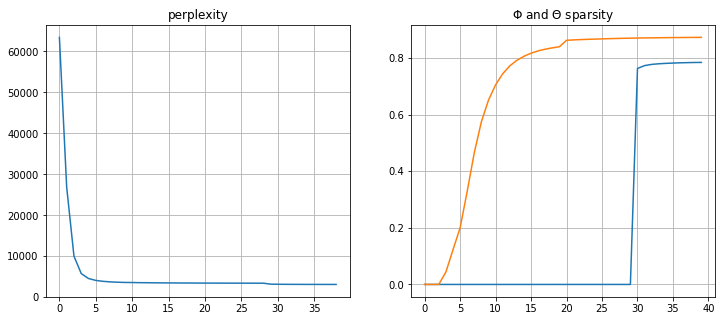

In [127]:
plot_perp_and_sparsity(model_news)
print_top_words(model_news)
test_accuracy(model_news)

#### accuracy=0.821
- dec - 0.05
- sparse_theta - 0.1
- sparse_phi - 1e-5

In [ ]:
model_news.fit_offline(batch_vectorizer=bv_news, num_collection_passes=10)

model_news.regularizers.add(
    artm.DecorrelatorPhiRegularizer(
        name='decorrelator_phi', tau=0.05, gamma=0, class_ids="@raw_text")#, overwrite=True
)
model_news.fit_offline(batch_vectorizer=bv_news, num_collection_passes=10)

In [105]:
test_accuracy(model_news)

0.7751855779427359

In [ ]:
model_news.regularizers.add(
    artm.SmoothSparseThetaRegularizer(
        name='sparse_theta', tau = -0.1/(1+0.1) * n_news/(T*D_news) # relative coef = 0.1
    ) #, overwrite=True
)
model_news.fit_offline(batch_vectorizer=bv_news, num_collection_passes=10)

In [ ]:
model_news.regularizers.add(
    artm.SmoothSparsePhiRegularizer(
        name='sparse_phi', tau=-1e-5, gamma=0, 
        dictionary=dictionary_news)#, overwrite=True
)

model_news.fit_offline(batch_vectorizer=bv_news, num_collection_passes=10)

topic 10: bike, dod, article, writes, motorcycle, one, ride, dog, like, posting, nntp, host, get, dont, riding
topic 0: christian, science, one, writes, article, people, say, think, child, koresh, dont, know, god, would, order
topic 5: mac, apple, problem, drive, bit, monitor, card, one, posting, speed, chip, university, simms, nntp, ram
topic 9: sale, price, offer, shipping, new, university, distribution, mail, edu, posting, nntp, host, condition, mov, please
topic 3: key, encryption, chip, clipper, government, security, privacy, system, use, would, one, public, law, escrow, information
topic 13: god, one, atheist, people, writes, dont, would, argument, think, say, religion, thing, article, human, atheism
topic 14: said, armenian, people, one, didnt, went, say, know, woman, dont, would, going, told, something, came
topic 1: wire, one, circuit, use, power, ground, would, need, host, like, university, get, current, outlet, article
topic 12: food, disease, medical, one, article, patient,

0.8211382113821138

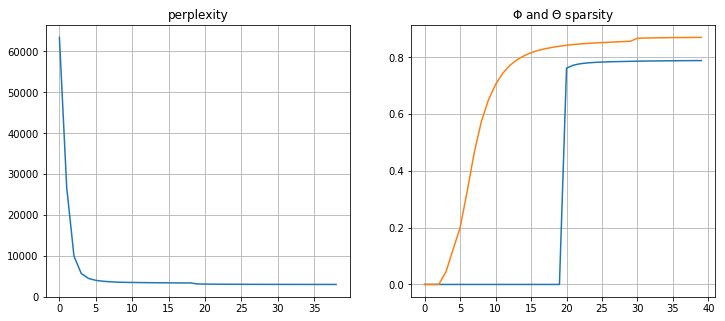

In [134]:
plot_perp_and_sparsity(model_news)
print_top_words(model_news)
test_accuracy(model_news)

### Gridsearching

In [186]:
acc = {}

In [184]:
def gridsearch(reg1_space=np.array((0.01, 0.03, 0.05)), reg2_space=np.linspace(0.01, 0.05, 5), reg3_space=np.linspace(1.2, 2., 5)):
    for t1 in tqdm_notebook(reg1_space):
        for t2 in tqdm_notebook(reg2_space):
            for t3 in tqdm_notebook(reg3_space):
                if 'models/news/{}_{}_{}'.format(round(t1, 4), round(t2, 3), round(t3, 6)) in acc.keys():
                    pass
                else:
                    bv_news, dictionary_news = read_collection("batches_train", "./20ng_train_artm.vw")
                    dictionary_news.filter(max_df_rate=0.95)

                    model_news = artm.ARTM(
                        topic_names=['topic {}'.format(i) for i in range(T)],
                        theta_columns_naming = 'title',
                        num_document_passes = 5,
                        class_ids={'@raw_text': 1.0, '@origin': 20.0}
                    )

                    model_news.scores.add(artm.PerplexityScore(name='perplexity_score', dictionary=dictionary_news))
                    model_news.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score', class_id='@raw_text'))
                    model_news.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
                    model_news.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id='@raw_text'))
                    np.random.seed(16)
                    model_news.initialize(dictionary_news)

                    model_news.fit_offline(batch_vectorizer=bv_news, num_collection_passes=10)

                    model_news.regularizers.add(
                        artm.DecorrelatorPhiRegularizer(
                            name='decorrelator_phi', tau=t1, gamma=0, class_ids="@raw_text")#, overwrite=True
                    )
                    model_news.fit_offline(batch_vectorizer=bv_news, num_collection_passes=10)

                    model_news.regularizers.add(
                        artm.SmoothSparseThetaRegularizer(
                            name='sparse_theta', tau = -t2/(1+t2) * n_news/(T*D_news))#, overwrite=True
                    )
                    model_news.fit_offline(batch_vectorizer=bv_news, num_collection_passes=10)

                    model_news.regularizers.add(
                        artm.SmoothSparsePhiRegularizer(
                            name='smooth_phi', tau=-t3, gamma=0, dictionary=dictionary_news)#, overwrite=True
                    )
                    model_news.fit_offline(batch_vectorizer=bv_news, num_collection_passes=10)

                    acc['models/news/{}_{}_{}'.format(round(t1, 4), round(t2, 3), round(t3, 6))] = test_accuracy(model_news)
                    model_news.save('models/news/{}_{}_{}'.format(round(t1, 4), round(t2, 3), round(t3, 6)))

In [188]:
acc

{'models/news/0.01_0.1_0.0001': 0.8236125839519265,
 'models/news/0.01_0.1_1e-05': 0.8236125839519265,
 'models/news/0.01_0.1_1e-06': 0.823966065747614,
 'models/news/0.01_0.1_3e-05': 0.8236125839519265,
 'models/news/0.01_0.1_3e-06': 0.823966065747614}

In [182]:
acc

{'models/news/0.01_0.01_0.0': 0.8140685754683634,
 'models/news/0.01_0.05_0.0': 0.8183103570166137,
 'models/news/0.01_0.1_0.0': 0.8236125839519265,
 'models/news/0.01_0.2_0.0': 0.8250265111346765}

In [142]:
acc

{'models/news/0.001_0.1_0.0': 0.8236125839519265,
 'models/news/0.005_0.1_0.0': 0.8236125839519265,
 'models/news/0.01_0.1_0.0': 0.8236125839519265,
 'models/news/0.05_0.1_0.0': 0.8211382113821138,
 'models/news/0.1_0.1_0.0': 0.7419582891481089}

In [ ]:
gridsearch([0.005, 0.01, 0.05], [0.2, 0.1], [1e-6, 5e-6, 1e-5, 5e-5])

In [197]:
for key in acc.keys():
    if acc[key] == max(acc.values()):
        print(key)

models/news/0.001_0.2_5e-06
models/news/0.005_0.2_1e-05
models/news/0.005_0.2_5e-06
models/news/0.005_0.2_1e-06
models/news/0.005_0.2_5e-05
models/news/0.01_0.2_1e-06
models/news/0.01_0.2_5e-06
models/news/0.001_0.2_1e-06
models/news/0.001_0.2_1e-05


In [199]:
print(max(acc.values()))

0.8250265111346765
